In [44]:
prefix = "/home/fneum/bwss/papers/import-benefits/workflow/pypsa-eur/"

SELECTION = "C"

if SELECTION == "A":
    network_fns = [
        prefix
        + "results/20231025-zecm/postnetworks/elec_s_110_lvopt__Co2L0-2190SEG-T-H-B-I-S-A-onwind+p0.5_2050.nc",
        prefix
        + "results/20231025-zecm/postnetworks/elec_s_110_lvopt__Co2L0-2190SEG-T-H-B-I-S-A-onwind+p0.5-imp_2050.nc",
        prefix
        + "results/20231025-zecm/postnetworks/elec_s_110_lvopt__Co2L0-2190SEG-T-H-B-I-S-A-onwind+p0.5-imp+H2_2050.nc",
    ]
    scenario_names = [
        "no imports allowed",
        "all imports allowed",
        "only hydrogen imports",
    ]
elif SELECTION == "B":
    network_fns = [
        prefix
        + "results/20231025-zecm/postnetworks/elec_s_110_lvopt__Co2L0-2190SEG-T-H-B-I-S-A-onwind+p0.5-nowasteheat_2050.nc",
        prefix
        + "results/20231025-zecm/postnetworks/elec_s_110_lvopt__Co2L0-2190SEG-T-H-B-I-S-A-onwind+p0.5-noH2network-imp_2050.nc",
        prefix
        + "results/20231025-zecm/postnetworks/elec_s_110_lvopt__Co2L0-2190SEG-T-H-B-I-S-A-onwind+p0.5-imp+AC_2050.nc",
    ]
    scenario_names = [
        "no PtX waste heat, no imports",
        "all imports allowed, no hydrogen network",
        "only electricity imports",
    ]
elif SELECTION == "C":
    network_fns = [
        prefix
        + "results/20231025-zecm/postnetworks/elec_s_110_lvopt__Co2L0-2190SEG-T-H-B-I-S-A-onwind+p0.5-imp+H20.8_2050.nc",
        prefix
        + "results/20231025-zecm/postnetworks/elec_s_110_lvopt__Co2L0-2190SEG-T-H-B-I-S-A-onwind+p0.5-imp+AC+H2+CH40.9+NH3+FT0.9+MeOH0.9+St_2050.nc",
        prefix
        + "results/20231025-zecm/postnetworks/elec_s_110_lvopt__Co2L0-2190SEG-T-H-B-I-S-A-onwind+p0.5-imp+AC+H2+CH40.8+NH3+FT0.8+MeOH0.8+St_2050.nc",
    ]
    scenario_names = [
        "only hydrogen imports, 20% cheaper",
        "10% cheaper C-fuel imports",
        "20% cheaper C-fuel imports",
    ]
elif SELECTION == "D":
    network_fns = [
        prefix
        + "results/20231025-zecm/postnetworks/elec_s_110_lvopt__Co2L0-2190SEG-T-H-B-I-S-A-onwind+p0.5-nosteelrelocation_2050.nc",
        prefix
        + "results/20231025-zecm/postnetworks/elec_s_110_lvopt__Co2L0-2190SEG-T-H-B-I-S-A-onwind+p0.5-noH2network-imp+AC+CH4+NH3+FT+MeOH+St_2050.nc",
        prefix
        + "results/20231025-zecm/postnetworks/elec_s_110_lvopt__Co2L0-2190SEG-T-H-B-I-S-A-onwind+p0.5-imp+CH4+NH3+FT+MeOH+St_2050.nc",
    ]
    scenario_names = [
        "no steel industry relocation, no imports",
        "imports without hydrogen, no hydrogen network",
        "only hydrogen derivative imports",
    ]

regions_fn = prefix + "resources/20231025-zecm/regions_onshore_elec_s_110.geojson"
matplotlibrc_fn = "../pypsa-eur/matplotlibrc"
import_fn = "../pypsa-eur/data/imports/results.csv"
config_fn = "../../config/config.yaml"


RUN = "20231025-zecm"
OUTPUT = f"./{RUN}/"

In [45]:
import sys
import yaml
import pypsa
import numpy as np
import pandas as pd
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from matplotlib.patches import Patch, Circle

# import country_converter as coco
# cc = coco.CountryConverter()

sys.path.append("../pypsa-eur/scripts")

from plot_power_network import assign_location as old_assign_location
from pypsa.plot import add_legend_circles, add_legend_lines


plt.style.use(["bmh", matplotlibrc_fn])

In [46]:
# from https://github.com/FabianHofmann/co2-network/blob/master/workflow/scripts/common.py
def assign_location(n):
    for c in n.one_port_components | n.branch_components:
        df = n.df(c)

        if "location" not in df:
            df["location"] = np.nan

        bus_col = df.columns[df.columns.str.startswith("bus")][0]
        df["location"] = df[bus_col].map(n.buses.location)


def assign_interconnection(n):
    for c in n.branch_components:
        df = n.df(c)
        if df.empty:
            continue

        location0 = df.bus0.map(n.buses.location)
        location1 = df.bus1.map(n.buses.location)
        locations = pd.concat([location0, location1], axis=1)
        df["location0"] = location0
        df["location1"] = location1

        connections = locations.apply(lambda ds: " - ".join(sorted(ds)), axis=1)
        connections = connections.where(location0 != location1)
        df["interconnection"] = connections


def fill_missing_carriers(n):
    for c in n.iterate_components(n.one_port_components | n.branch_components):
        new_carriers = set(c.df.carrier.unique()) - set(n.carriers.index)
        if new_carriers:
            n.madd("Carrier", list(new_carriers))


def sanitize_locations(n):
    old_assign_location(n)
    if "EU" in n.buses.index:
        n.remove("Bus", "EU")
    n.add("Bus", "EU", x=-6.5, y=44.5)
    n.buses.loc[n.buses.index.str.startswith("EU"), "location"] = "EU"
    iso2_buses = n.buses.index.str.len() == 2
    n.buses.loc[iso2_buses, "location"] = n.buses.index[iso2_buses]
    copperplated = ["co2 atmosphere", "process emissions", "solid biomass for industry"]
    n.buses.loc[copperplated, "location"] = "EU"
    assign_location(n)
    assign_interconnection(n)
    fill_missing_carriers(n)
    n.buses["x"] = n.buses.location.map(n.buses.x)
    n.buses["y"] = n.buses.location.map(n.buses.y)
    if "KZ" in n.buses.index:
        n.buses.loc["KZ", "x"] = 52
        n.buses.loc["KZ", "y"] = 49
    if "CN-West" in n.buses.index:
        n.buses.loc["CN-West", "x"] = 79
        n.buses.loc["CN-West", "y"] = 38
    for ct in n.buses.index.intersection({"MA", "DZ", "TN", "LY", "EG", "SA"}):
        n.buses.loc[ct, "y"] += 2


def get_transmission_links(n, with_eu=False):
    # only choose transmission links
    if with_eu:
        return n.links.bus0.map(n.buses.location) != n.links.bus1.map(n.buses.location)
    return (
        (n.links.bus0.map(n.buses.location) != n.links.bus1.map(n.buses.location))
        & ~n.links.bus0.map(n.buses.location).str.contains("EU")
        & ~n.links.bus1.map(n.buses.location).str.contains("EU")
    )

In [47]:
with open(config_fn, "r") as f:
    config = yaml.safe_load(f)
tech_colors = config["plotting"]["tech_colors"]
nice_names = config["plotting"]["nice_names"]

In [48]:
df = pd.read_csv(import_fn, sep=";", keep_default_na=False)
df["exporter"] = df.exporter.replace("", "NA")
ic = df.query(
    "subcategory == 'Cost per MWh delivered' and esc == 'pipeline-h2'"
).rename(columns={"value": "marginal_cost"})

In [49]:
ns = [pypsa.Network(fn) for fn in network_fns]

INFO:pypsa.io:Imported network elec_s_110_lvopt__Co2L0-2190SEG-T-H-B-I-S-A-onwind+p0.5-imp+H20.8_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_110_lvopt__Co2L0-2190SEG-T-H-B-I-S-A-onwind+p0.5-imp+AC+H2+CH40.9+NH3+FT0.9+MeOH0.9+St_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_110_lvopt__Co2L0-2190SEG-T-H-B-I-S-A-onwind+p0.5-imp+AC+H2+CH40.8+NH3+FT0.8+MeOH0.8+St_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [50]:
for n in ns:
    sanitize_locations(n)

In [51]:
crs = ccrs.EqualEarth()

In [52]:
regions = gpd.read_file(regions_fn).set_index("name").to_crs(crs.proj4_init)

In [53]:
def get_dispatch(n):
    is_transport = get_transmission_links(n)
    transport_carriers = [
        *n.links.carrier[is_transport].unique(),
        *n.lines.carrier.unique(),
    ]

    balance = n.statistics.energy_balance(nice_names=False, aggregate_bus=False)
    balance = balance.rename(n.buses.location, level=3)
    dispatch = balance.drop(transport_carriers, level=1)

    return dispatch

In [54]:
n = ns[1]

In [55]:
def get_copperplated_imports(n):

    eu_sizes = {}

    weights = n.snapshot_weightings.generators
    carriers = ["import shipping-lnh3", "import shipping-steel"]
    for carrier in carriers:
        if carrier in n.generators.carrier.unique():
            conversion_factor = 2.1 if "steel" in carrier else 1  # kWh/kg for steel
            carrier_i = n.generators[n.generators.carrier == carrier].index
            energy = weights @ n.generators_t.p.loc[:, carrier_i]
            eu_sizes[("EU", carrier.split(" ")[-1])] = energy.sum() / conversion_factor

    carriers = [
        "import shipping-lch4",
        "import shipping-ftfuel",
        "import shipping-meoh",
    ]
    for carrier in carriers:
        if carrier in n.links.carrier.unique():
            carrier_i = n.links[n.links.carrier == carrier].index
            energy = weights @ n.links_t.p0.loc[:, carrier_i]
            eu_sizes[("EU", carrier.split(" ")[-1])] = energy.sum()

    eu_sizes = pd.Series(eu_sizes, dtype=float)
    if not eu_sizes.empty:
        eu_sizes.index.names = ["bus", "carrier"]

    return eu_sizes

/home/fneum/miniconda3/envs/pypsa-eur/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/fneum/miniconda3/envs/pypsa-eur/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/fneum/miniconda3/envs/pypsa-eur/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/fneum/miniconda3/envs/pypsa-eur/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/fneum/miniconda3/envs/pypsa-eur/lib/python3.11/site-packag

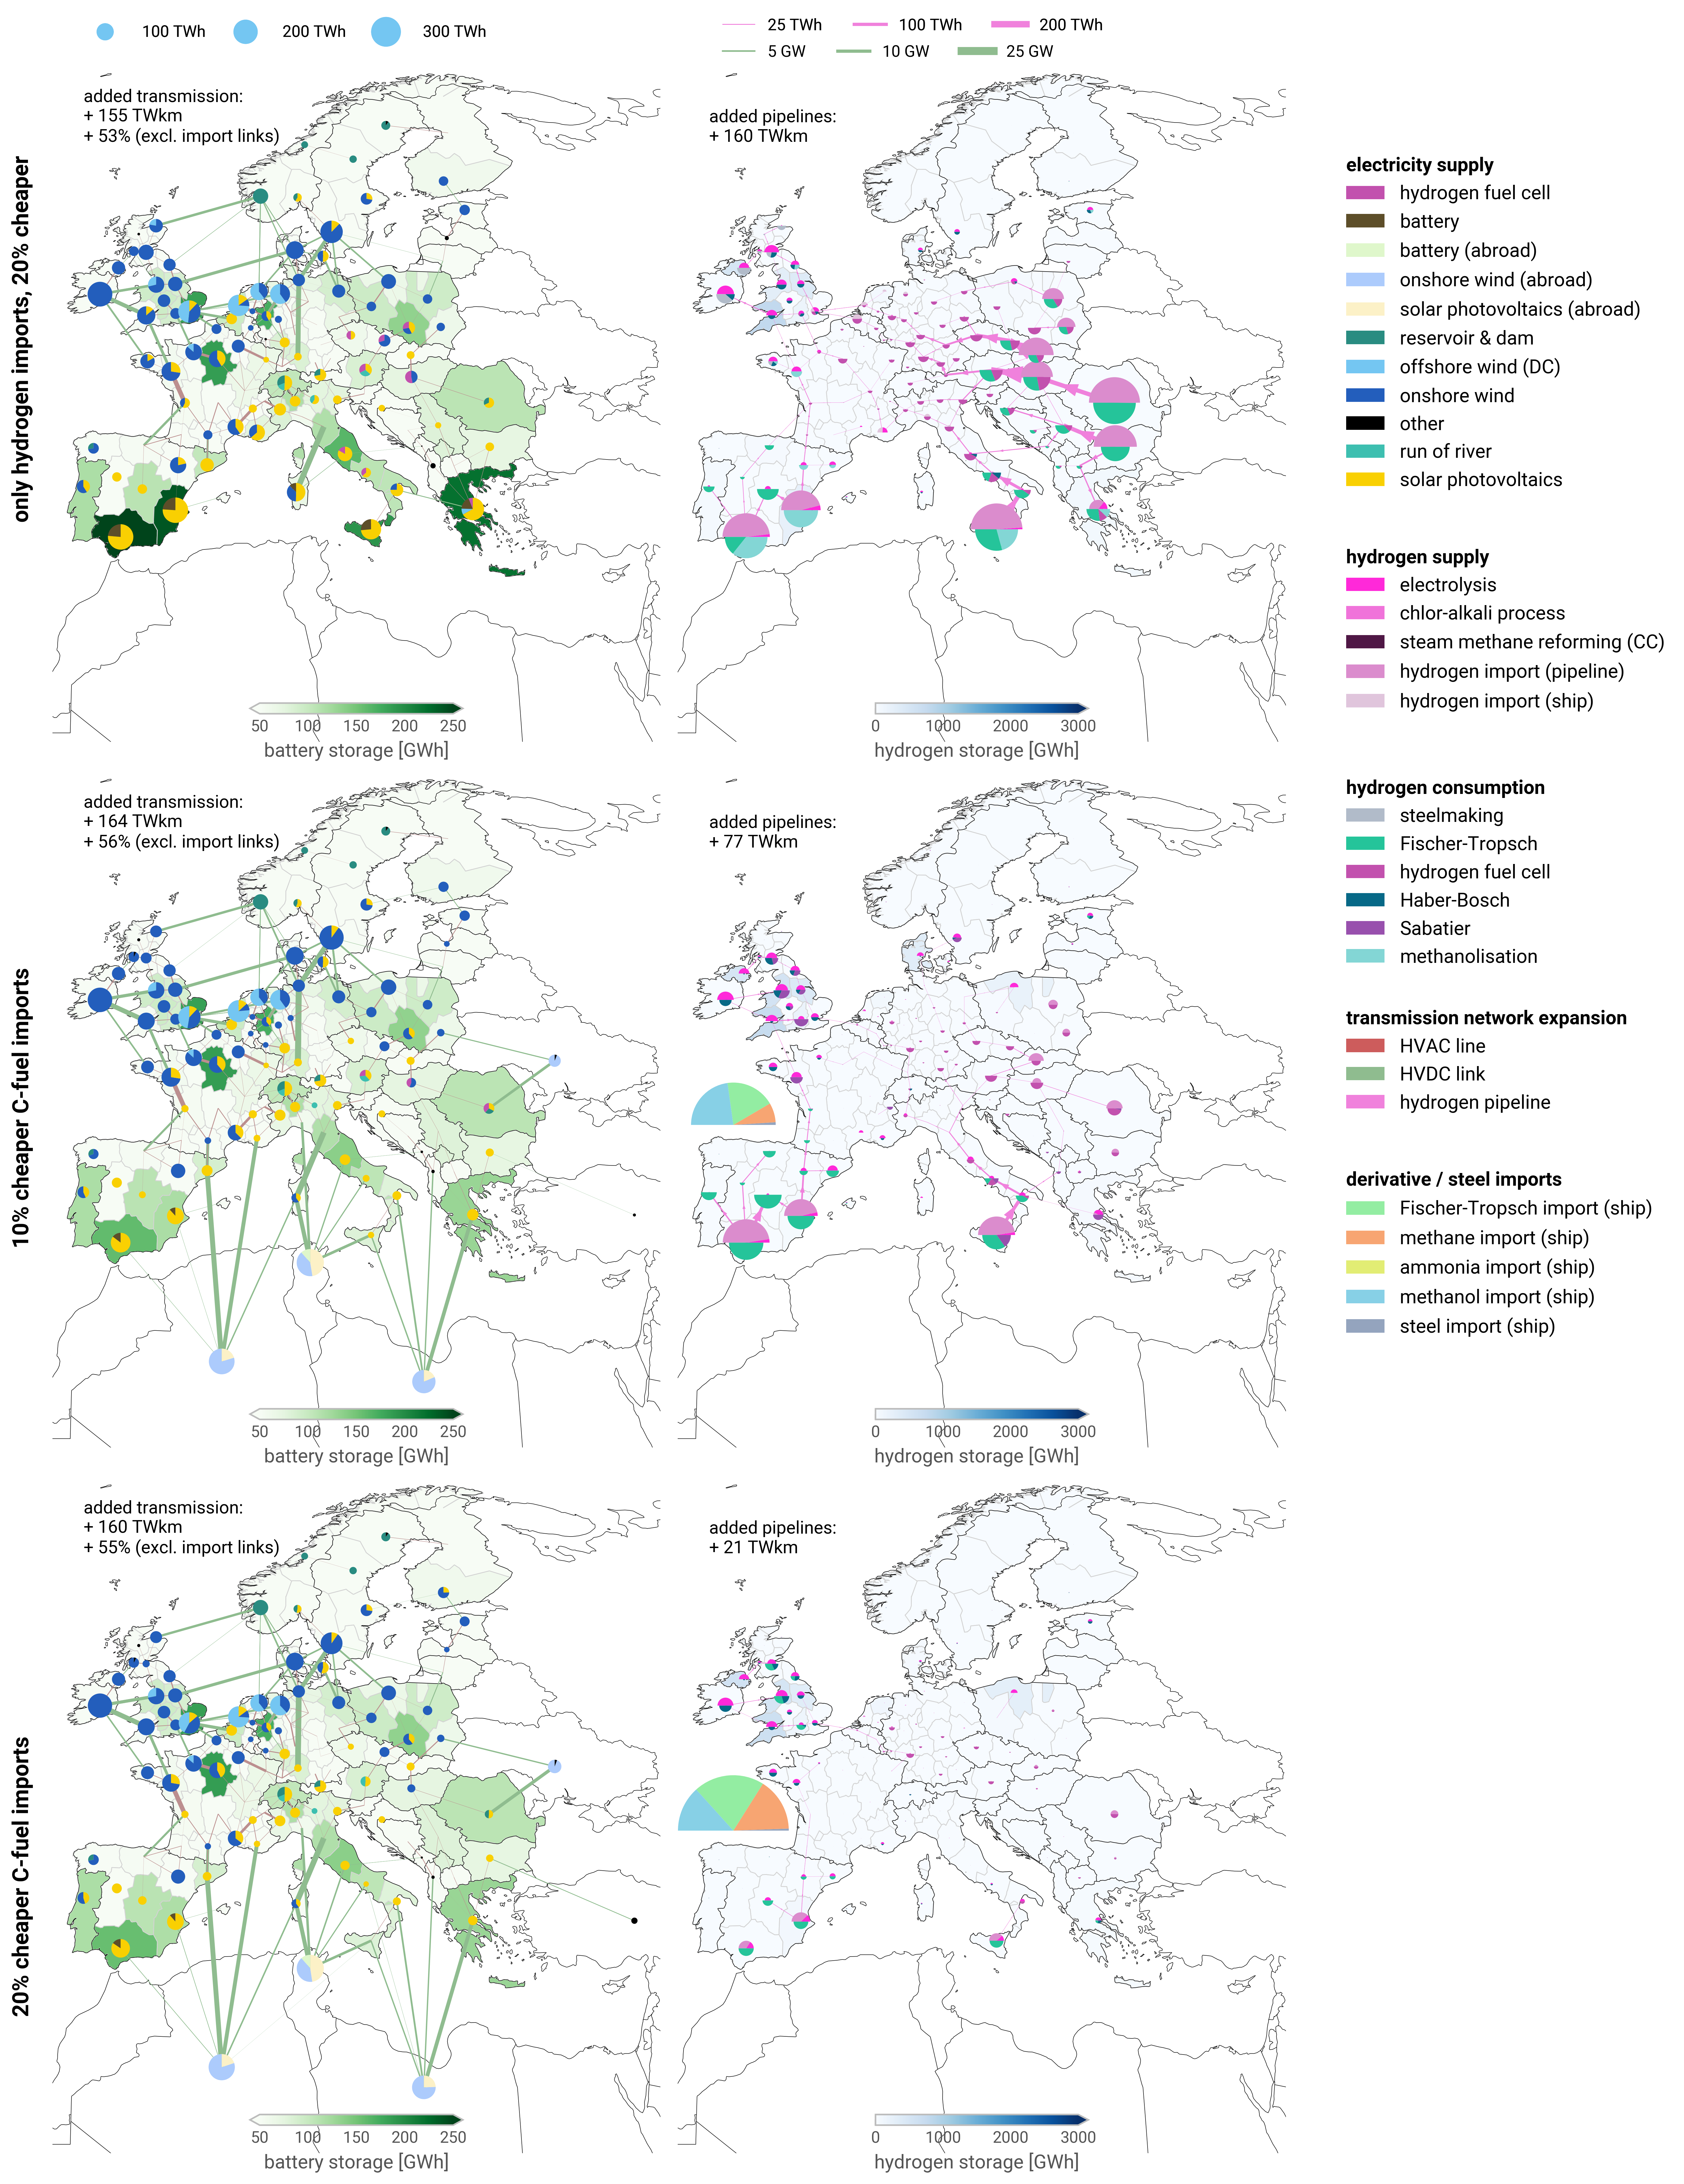

In [56]:
from matplotlib.transforms import Bbox

BOUNDARIES = [-10, 35.25, 25.5, 71.5]

fig, axs = plt.subplots(
    3,
    2,
    subplot_kw={"projection": crs},
    figsize=(11, 20),
)

plt.subplots_adjust(wspace=0, hspace=0, right=0.2, left=0.15)

elec_labels = []
h2_supply_labels = []
h2_demand_labels = []
eu_import_labels = []

for i, n in enumerate(ns):

    regions["battery"] = (
        n.stores.filter(like="battery", axis=0)
        .groupby("location")
        .e_nom_opt.sum()
        .div(1e3)
    )
    regions["hydrogen"] = (
        n.stores.filter(like="H2 Store", axis=0)
        .groupby("location")
        .e_nom_opt.sum()
        .div(1e3)
    )

    dispatch = get_dispatch(n)

    # power network

    bus_scale = 5e-9
    branch_scale_el = 2e-4

    bus_sizes = dispatch.xs("AC", level="bus_carrier").groupby(["bus", "carrier"]).sum()
    mask = bus_sizes < 10e6
    bus_sizes.index = pd.MultiIndex.from_tuples(
        [(idx[0], "other" if mask.loc[idx] else idx[1]) for idx in bus_sizes.index]
    )
    bus_sizes = bus_sizes.groupby(level=[0, 1]).sum()

    branch_widths = {}
    carriers = ["AC", "DC", "import hvdc-to-elec"]
    links = n.links.query("carrier in @carriers")
    df = links.p_nom_opt - links.p_nom_min
    branch_widths["Link"] = df[df > 100]
    lines = n.lines.query("carrier in @carriers")
    df = lines.s_nom_opt - lines.s_nom_min
    branch_widths["Line"] = df[df > 100]

    elec_labels += bus_sizes.index.get_level_values(1).unique().tolist()

    n.plot(
        ax=axs[i, 0],
        bus_sizes=bus_sizes * bus_scale,
        bus_colors=tech_colors,
        line_widths=branch_widths["Line"].abs().reindex(n.lines.index, fill_value=0)
        * branch_scale_el,
        link_widths=branch_widths["Link"].abs().reindex(n.links.index, fill_value=0)
        * branch_scale_el,
        boundaries=BOUNDARIES,
        margin=0.15,
    )

    regions.plot(
        ax=axs[i, 0],
        column="battery",
        cmap="Greens",
        linewidths=0.5,
        edgecolor="lightgray",
        legend=True,
        vmin=50,
        vmax=250,
        legend_kwds={
            "label": r"battery storage [GWh]",
            "shrink": 0.35,
            "pad": -0.045,
            "orientation": "horizontal",
            "extend": "both",
        },
    )


    existing_twkm = (
        n.links.query("carrier == 'DC'").eval("p_nom * length").sum()
        + n.lines.eval("s_nom * length").sum()
    )
    optimised_twkm = (
        n.links.query("carrier == 'DC'").eval("p_nom_opt * length").sum()
        + n.lines.eval("s_nom_opt * length").sum()
    )
    increase_twkm_rel = round((optimised_twkm - existing_twkm) / existing_twkm * 100)
    increase_twkm_abs = round((optimised_twkm - existing_twkm) / 1e6)

    axs[i, 0].text(
        -70e4,
        730e4,
        f"added transmission:\n+ {increase_twkm_abs} TWkm\n+ {increase_twkm_rel}% (excl. import links)",
        fontsize=11,
        transform=crs,
    )

    fig.text(
        -0.01,
        1 - (2 * i + 1) / 6,
        scenario_names[i],
        va="center",
        ha="center",
        rotation="vertical",
        size=14,
        fontweight="bold",
    )

    # hydrogen network

    bus_scale = 5e-9
    branch_scale_h2 = 2e-8
    flow_scale = 2e-5

    bus_sizes = dispatch.xs("H2", level="bus_carrier").groupby(["bus", "carrier"]).sum()
    copperplated_imports = get_copperplated_imports(n)
    bus_sizes = pd.concat([bus_sizes, copperplated_imports])
    bus_sizes = bus_sizes[bus_sizes.abs() > 10]

    branch_widths = {}
    carriers = ["H2 pipeline"]
    weights = n.snapshot_weightings.generators
    links = n.links.query("carrier in @carriers")
    df = weights @ n.links_t.p0[links.index]
    branch_widths["Link"] = df[df > 5e6]
    lines = n.lines.query("carrier in @carriers")
    df = weights @ n.lines_t.p0[lines.index]
    branch_widths["Line"] = df[df > 5e6]
    flow = pd.concat(branch_widths)

    h2_supply_labels += (
        bus_sizes[bus_sizes > 0]
        .drop(copperplated_imports.index, errors="ignore")
        .index.get_level_values(1)
        .unique()
        .tolist()
    )
    h2_demand_labels += (
        bus_sizes[bus_sizes < 0].index.get_level_values(1).unique().tolist()
    )
    if not copperplated_imports.empty:
        eu_import_labels += (
            copperplated_imports.index.get_level_values(1).unique().tolist()
        )

    n.plot(
        ax=axs[i, 1],
        bus_sizes=bus_sizes * bus_scale,
        bus_colors=tech_colors,
        line_widths=branch_widths["Line"].abs().reindex(n.lines.index, fill_value=0)
        * branch_scale_h2,
        link_widths=branch_widths["Link"].abs().reindex(n.links.index, fill_value=0)
        * branch_scale_h2,
        flow=flow * flow_scale,
        link_colors=tech_colors["H2 pipeline"],
        bus_split_circles=True,
        margin=0.15,
        boundaries=BOUNDARIES,
    )

    regions.plot(
        ax=axs[i, 1],
        column="hydrogen",
        cmap="Blues",
        linewidths=0.5,
        edgecolor="lightgray",
        legend=True,
        vmin=0,
        vmax=3000,
        legend_kwds={
            "label": r"hydrogen storage [GWh]",
            "shrink": 0.35,
            "pad": -0.045,
            "orientation": "horizontal",
            "extend": "max",
        },
    )

    optimised_twkm = (
        n.links.query("carrier == 'H2 pipeline'").eval("p_nom_opt * length").sum()
    )
    increase_twkm_abs = round(optimised_twkm / 1e6)

    axs[i, 1].text(
        -70e4,
        730e4,
        f"added pipelines:\n+ {increase_twkm_abs} TWkm",
        fontsize=11,
        transform=crs,
    )

    # if i == 0:
    #    break


def create_legend(labels, title, anchor_y):
    legend_kw = dict(
        loc="upper left",
        bbox_to_anchor=(1.02, anchor_y),
        frameon=False,
        # title=title,
        alignment="left",
        bbox_transform=fig.transFigure,
        fontsize=12,
        # title_fontsize=12,
    )
    unique_labels = np.unique(labels)
    colors = [tech_colors.get(l, "gray") for l in unique_labels]
    nice_labels = [nice_names.get(l, l) for l in unique_labels]
    handles = [Patch(facecolor=c) for c in colors]
    legend = fig.legend(handles, nice_labels, **legend_kw)
    legend.set_title(title, prop={"size": 12, "weight": "bold"})


transmission_labels = ["AC", "DC", "H2 pipeline"]
create_legend(elec_labels, "electricity supply", 0.92)
create_legend(h2_supply_labels, "hydrogen supply", 0.75)
create_legend(h2_demand_labels, "hydrogen consumption", 0.65)
create_legend(transmission_labels, "transmission network expansion", 0.55)
create_legend(eu_import_labels, "derivative / steel imports", 0.48)

legend_kw = dict(
    loc="upper left",
    bbox_to_anchor=(0.05, 1.09),
    frameon=False,
    ncol=3,
    labelspacing=1.1,
)

add_legend_circles(
    axs[0, 0],
    [100e6 * bus_scale, 200e6 * bus_scale, 300e6 * bus_scale],
    ["100 TWh", "200 TWh", "300 TWh"],
    patch_kw=dict(facecolor=tech_colors["offwind-dc"]),
    legend_kw=legend_kw,
)

legend_kw = dict(
    loc="upper left",
    bbox_to_anchor=(0.05, 1.06),
    frameon=False,
    labelspacing=0.8,
    ncol=3,
)

add_legend_lines(
    axs[0, 1],
    [5e3 * branch_scale_el, 10e3 * branch_scale_el, 25e3 * branch_scale_el],
    ["5 GW", "10 GW", "25 GW"],
    patch_kw=dict(color=tech_colors["DC"]),
    legend_kw=legend_kw,
)

legend_kw = dict(
    loc="upper left",
    bbox_to_anchor=(0.05, 1.1),
    frameon=False,
    labelspacing=0.8,
    ncol=3,
)

add_legend_lines(
    axs[0, 1],
    [25e6 * branch_scale_h2, 100e6 * branch_scale_h2, 200e6 * branch_scale_h2],
    ["25 TWh", "100 TWh", "200 TWh"],
    patch_kw=dict(color=tech_colors["H2 pipeline"]),
    legend_kw=legend_kw,
)

fig.canvas.draw()

for ext in [".pdf", ".png"]:
    plt.savefig(
        OUTPUT + "infrastructure-map-2x3-" + SELECTION + ext,
        dpi=fig.dpi,
        bbox_inches=Bbox([[-0.5, 0.5], [14.5, 19.6]]),
    )